In [5]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# !mkdir -p '/kaggle/temp/'
# #!tar -xvzf '../input/200-bird-species-with-11788-images/CUB_200_2011.tgz' --directory '/kaggle/temp/'
# !tar -xzf '../input/200-bird-species-with-11788-images/CUB_200_2011.tgz' --directory '/kaggle/temp/'

In [8]:
# import os
# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [9]:
#%%
import tensorflow as tf
print('TF version: ', tf.__version__)

#%% 
"""fix for issue: cuDNN failed to initialize"""
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('...GPU set_memory_growth successfully set...')

else:
    print('...GPU set_memory_growth not set...')

#%%
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,Softmax, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import math
#from tf_explain_modified.core.grad_cam import GradCAM
import datetime
from tqdm import tqdm # to monitor progress
import argparse
import os, sys

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


from tensorflow.keras import optimizers


# from models10 import MySubClassModel
# from codes.compute_filter_importance import save_filter_importance, test_filter_importance,test_filter_importance_in_code_method, plot_filter_importance,check_top_filter_importance,save_filter_importance_batch, check_histogram_top_filter_result
# from codes.load_cxr_dataset import create_cxr_dataframes, load_cxr_dataset
# from codes.support_functions import print_filter_classes_1, print_filter_classes_2, save_interpretable_parameters
# from codes.find_filter_class import find_filter_class
# from codes.train_counterfactual_net import train_counterfactual_net
# from codes.support_functions import get_heatmap_only

TF version:  2.1.0
...GPU set_memory_growth successfully set...


In [15]:
#%%
KAGGLE = True
parser = argparse.ArgumentParser(description='Interpretable CNN')
parser.add_argument('--interpretable',default = False)
parser.add_argument('--full_standard',default = True)## dont add extra cnn layer to be comparable with interpretable model. Make completely standalone model
parser.add_argument('--train_using_builtin_fit_method',default = True)#for training base model easily

parser.add_argument('--create_counterfactual_combined' ,default = False)## create CF model for a pretrained base model or train a new base model

parser.add_argument('--train_counterfactual_net' ,default = False)## 
parser.add_argument('--resume_counterfactual_net' ,default = False)## 
parser.add_argument('--test_counterfactual_net' ,default = False)## 
parser.add_argument('--load_counterfactual_net',default = True)


parser.add_argument('--resume', default =False) # load saved weights for base model
parser.add_argument('--pretrained', default = False) # load self-pretrained model

parser.add_argument('--find_filter_class', default = False) # load retrained model and assign class to each filter by check mean activation per filter per class

parser.add_argument('--filter_modified_directly', default = True)
parser.add_argument('--loss_compute', default = True)#False = forward only
parser.add_argument('--high_capacity_model', default = True)#
parser.add_argument('--fixed_classes', default = True)#idea 2: fine tune from forward only with fixed classes
parser.add_argument('--fixed_classes_reduce_loss', default = True)#False = forward only masked with fixed filter class. issue: 100% training accuracy but 10% testing acc

parser.add_argument('--test_filter_importance', default = False)#for testing idea 2
parser.add_argument('--save_filter_importance', default = False)#for testing idea 2
parser.add_argument('--analyze_filter_importance', default = False)#for testing idea 2
parser.add_argument('--save_filter_fmap', default = False)#save filter fmap as well
parser.add_argument('--save_top_layer', default = True)#save top layer filter data only

parser.add_argument('--visualize_fmaps', default = False)

#base model parameters
parser.add_argument('--dataset',default = 'CUB200')#mnist, cifar10, CUB200, #cxr1000, #catsvsdogs, #VOC2010
parser.add_argument('--save_directory',default = './trained_weights/')
parser.add_argument('--train',default = True)
parser.add_argument('--test', default = True)
parser.add_argument('--model',default = 'resnet50/')#myCNN, VGG16,resnet50
parser.add_argument('--imagenet_weights',default = True) #use imageNet pretrained VGG

parser.add_argument('--filter_category_method',default = 'own_reduce_loss')   # paper --> similar to paper implementation---assign filter with categories during training by accumulating batch-wise max activations
                                                                    # own_reduce_loss --> our idea - pre-assign filter categories during forward pass over all the data, based on pretrained weights and feature maps


#parser.add_argument('--test',default = True)
 
if KAGGLE: args = parser.parse_known_args()[0] 
else: args = parser.parse_args()

if args.interpretable:
    if args.filter_category_method=='paper':
        print('filter category assignment --> paper method')
    else:
        print('filter category assignment --> our idea')
    weights_path = args.save_directory+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
    log_path  = './logs/'+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
    filter_data_path = './create_training_data/'+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
else:
    weights_path = args.save_directory+args.model+args.dataset+'/standard'
    log_path  = './logs/'+args.model+args.dataset+'/standard'
    filter_data_path = './create_training_data/'+args.model+args.dataset+'/standard' #directory for saving filter importance training data
    
if not os.path.exists(weights_path):
    os.makedirs(weights_path)    
print('save_path: ',weights_path)

parser.add_argument('--save_path',default = weights_path)
if KAGGLE: args = parser.parse_known_args()[0] 
else: args = parser.parse_args()

if args.resume:
    print("resuming training")
#print(args)

if args.model == 'VGG16/':
    from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions, preprocess_input
elif args.model == 'resnet50/':
    from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input


save_path:  ./trained_weights/resnet50/CUB200/standard


In [11]:
KAGGLE = False
#(for jupyterbook issue)

In [12]:
#%%
batch_size = 32
if args.dataset == 'mnist':
    num_classes=10
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train,-1)
    x_test = np.expand_dims(x_test,-1)
    input_shape = (batch_size,28,28,1)
    label_map = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

elif args.dataset == 'cifar10':
    num_classes=10
    print('cifar-10 dataset')
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    input_shape = (batch_size,32,32,3)
    label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

elif args.dataset == 'CUB200':
    print('CUB200-2011 dataset')
    num_classes=200
    input_shape = (batch_size,224,224,3)
    official_split=True
    lab_system=True
    if KAGGLE:
        if official_split:
            print('official split not established for training on KAGGLE')
            sys.exit()
        else:
            base_path = '/kaggle/temp/CUB_200_2011'
    if lab_system:
        base_path ='D:/Ali Tariq/CUB_200_2011'
    else:
        base_path = 'G:/CUB_200_2011/CUB_200_2011'
    
    if official_split:
        data_dir =base_path+'/train_test_split/train/'
        data_dir_test =base_path+'/train_test_split/test/'
        label_map = np.loadtxt(fname=base_path + '/classes.txt',dtype='str')
        label_map = label_map[:,1]
        print('using official split')
    else:
        data_dir =base_path+'/images/'
        label_map = np.loadtxt(fname=base_path + '/classes.txt',dtype='str')
        label_map = label_map[:,1]

elif args.dataset == 'cxr1000':
    print('CXR-1000 dataset')
    num_classes=15
    input_shape = (batch_size,224,224,3)
    label_map, train_df, test_df, valid_df = create_cxr_dataframes()
    all_labels = label_map
elif args.dataset == 'catsvsdogs':
    print('catsvsdogs dataset')
    num_classes=2
    input_shape = (batch_size,224,224,3)
    lab_system = False
    if lab_system:
        data_dir ='D:/Ali Tariq/catsvsdogs/train/'
        data_dir_test ='D:/Ali Tariq/catsvsdogs/test/'    
    else:
        data_dir ='G:/catsvsdogs/train/'
        data_dir_test ='G:/catsvsdogs/test/'

    label_map = ['cat',  'dog']

elif args.dataset == 'VOC2010':
    print('VOC2010-animals dataset')
    num_classes=6
    input_shape = (batch_size,224,224,3)
    lab_system = False
    if lab_system:
        data_dir ='D:/Ali Tariq/VOCdevkit/VOC_animals/'
        #data_dir_test ='D:/Ali Tariq/catsvsdogs/test/'    
    else:
        #data_dir ='G:/VOCdevkit/VOC_animals_one/'
        data_dir ='G:/VOCdevkit/VOC_animals/'
        #data_dir_test ='G:/catsvsdogs/test/'

    label_map = ['bird',  'cat', 'cow', 'dog', 'horse', 'sheep']#['cat']#

else:
    print('unknown dataset')
    sys.exit()

CUB200-2011 dataset
using official split


In [13]:
label_map

array(['001.Black_footed_Albatross', '002.Laysan_Albatross',
       '003.Sooty_Albatross', '004.Groove_billed_Ani',
       '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet',
       '008.Rhinoceros_Auklet', '009.Brewer_Blackbird',
       '010.Red_winged_Blackbird', '011.Rusty_Blackbird',
       '012.Yellow_headed_Blackbird', '013.Bobolink',
       '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting',
       '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird',
       '020.Yellow_breasted_Chat', '021.Eastern_Towhee',
       '022.Chuck_will_Widow', '023.Brandt_Cormorant',
       '024.Red_faced_Cormorant', '025.Pelagic_Cormorant',
       '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper',
       '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo',
       '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo',
       '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch',
       '036.Northern_Flicker', '037.Acadian_Flycatcher',
       '038.Grea

In [16]:
#%%
if args.imagenet_weights:
    print('using imagenet_weights')

    if args.dataset == 'cifar10':
        imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)
                                        #rescale = 1./255)

        train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
        test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)
    else:
        augment = False
        if not augment:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                            #rescale = 1./255,
                                            validation_split=0.1)
        else:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                        #rescale = 1./255,
                                        validation_split=0.1,
                                        
                              height_shift_range= 0.2, 
                              width_shift_range=0.2, 
                              rotation_range=15, 
                              shear_range = 0.2,
                              fill_mode = 'nearest',#''nearest#reflect
                              zoom_range=0.2)
        
        train_gen = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest')#,
                                #all classes for base model; binary classes for CF model
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen  = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest')#,
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                               # classes = label_map)
        
        # for visualization, dont use preprocessed image
        imgDataGen_nopreprocess = ImageDataGenerator(#preprocessing_function = preprocess_input, 
                                        rescale = 1./255,
                                        validation_split=0.1)
        
        train_gen_nopreprocess = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen_nopreprocess  = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_
        if args.dataset == 'CUB200' and official_split:
            #actual unseen test set
            imgDataGen_official_split = ImageDataGenerator(preprocessing_function = preprocess_input)
            actual_test_gen  = imgDataGen_official_split.flow_from_directory(data_dir_test,
                            target_size=(input_shape[1], input_shape[2]),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batch_size,
                            shuffle=False,
                            seed=None,
                            #subset='validation',
                            interpolation='nearest')
            imgDataGen_official_split_nopreprocess = ImageDataGenerator(rescale = 1./255)
            actual_test_gen_nopreprocess  = imgDataGen_official_split_nopreprocess.flow_from_directory(data_dir_test,
                            target_size=(input_shape[1], input_shape[2]),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batch_size,
                            shuffle=False,
                            seed=None,
                            #subset='validation',
                            interpolation='nearest')
elif args.dataset == 'cxr1000':
    train_gen, test_gen, valid_gen = load_cxr_dataset(train_df, test_df, valid_df, all_labels, batch_size)
    
else:
    print('not using imagenet_weights')

    imgDataGen = ImageDataGenerator(rescale = 1./255)

    train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
    test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)



using imagenet_weights
Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


In [32]:
#%%
if args.imagenet_weights:
    print('loading VGG model')
    if args.dataset == 'cxr1000':
        tr = 1
        if tr:
            print('using imagenet weights for CXR dataset')
            vgg = VGG16(weights='imagenet',include_top = True)#top needed to get output dimensions at each layer
                # EfficientNetB0(include_top=True,
                #                weights=None,
                #                input_shape=img_shape,
                #                classes=len(all_labels),
                #                classifier_activation='sigmoid')
            base_model = tf.keras.Model(vgg.input,vgg.layers[-6].output)
            #model.compile(optimizer = optimizers.RMSprop(), loss = 'binary_crossentropy',#adam #weighted_binary_crossentropy #lr=0.001/2#binary_crossentropy
                                       #metrics = ['binary_accuracy'])#,tf.keras.metrics.AUC()])
        else:
            print('loading saved model - NOT IMPLEMENTED YET')
            #model = load_model('../input/efnb0-saved-weights/xray_class_EfficientNetB4_15_class_CEL_heatmap_imagenet_pretrained_weights.05-0.1807.hdf5')
        
        #model.summary()
    elif args.dataset == 'cifar10':
        print('using imagenet weights for cifar10 dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(32,32,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
    elif args.dataset == 'CUB200':
        if args.model == 'VGG16/':
           print('using VGG16 imagenet weights for CUB200 dataset')
           vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
           freeze=True
           if freeze:
               for layer in vgg.layers:
                   print (layer.name)
                   if layer.name == '----block5_conv3': continue
                   else: layer.trainable = False
           base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
        elif args.model == 'resnet50/':
           print('using resnet50 imagenet weights for CUB200 dataset')
           vgg = ResNet50(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
           freeze=True
           if freeze:
               for layer in vgg.layers:
                   print (layer.name)
                   if layer.name == '----block5_conv3': continue
                   else: layer.trainable = False
           base_model = tf.keras.Model(vgg.input,vgg.output)
    elif args.dataset == 'catsvsdogs':
        print('using imagenet weights for catsvsdogs dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
    elif args.dataset == 'VOC2010':
        print('using imagenet weights for VOC2010-animals dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
else:
    #base_model = VGG16(weights=None,include_top = False)
    base_model = MyFunctionalModel()


loading VGG model
using resnet50 imagenet weights for CUB200 dataset
input_7
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_

In [33]:
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [34]:
#%% create base model
if args.full_standard:
    top_filters = base_model.output_shape[3] # flters in top conv layer (512 for VGG)
    fmatrix = tf.keras.layers.Input(shape=(top_filters))
    #flag = tf.keras.layers.Input(shape=(1))
    
    if args.model == 'VGG16/':
        x =  MaxPool2D()(base_model.output)
    elif args.model == 'resnet50/':
        x =  base_model.output
    mean_fmap = GlobalAveragePooling2D()(x)
    

    
    #modify base model (once it has been pre-trained separately) to be used with CF model later
    if args.create_counterfactual_combined:
        #modified_fmap = tf.cond(tf.reduce_sum(fmatrix)>511, lambda: mean_fmap, lambda: mean_fmap*fmatrix)#modified_fmap = mean_fmap*fmatrix
        modified_fmap = mean_fmap*fmatrix
        pre_softmax = Dense(num_classes,activation=None)(modified_fmap)
        x = tf.keras.layers.Activation('softmax')(pre_softmax)
        model = tf.keras.Model(inputs=[base_model.input, fmatrix], outputs= [x,base_model.output, mean_fmap, modified_fmap,pre_softmax],name='VGG_base_model')
        default_fmatrix = tf.ones((train_gen.batch_size,base_model.output.shape[3]))
    else:
        x = tf.keras.layers.Dropout(0.5)(mean_fmap)
        
        #x = Dense(512,activation='relu')(x)
        #x = tf.keras.layers.Dropout(0.2)(x)
        
        #x = Dense(512,activation='relu')(x)

        x = Dense(num_classes,activation='softmax')(x)
        if args.train_using_builtin_fit_method:
            model = tf.keras.Model(inputs=base_model.input, outputs= [x])#, base_model.output])
        else:
            model = tf.keras.Model(inputs=base_model.input, outputs= [x, base_model.output])
else:
    model = MySubClassModel(num_classes=num_classes, base_model=base_model, args=args)
    #model = base_model
    model(tf.zeros(input_shape))
    #model.build(input_shape = input_shape)

model.summary()

#model.load_weights('./trained_weights/VGG16/CUB200/standard/model.09-2.3280.hdf5')
#load saved weights
if args.resume:
    #model.load_weights('./trained_weights/myCNN/cifar10/standard/model.hdf5')
    #model.load_weights('./trained_weights/myCNN/cifar10/interpretable/filter_category_method_paper/from_pretrained_model.hdf5')
    model.load_weights(filepath=weights_path+'/model.hdf5')
    #model.load_weights('./trained_weights/myCNN/cifar10/interpretable/filter_category_method_paper/model.hdf5')

    print("weights loaded")
if args.pretrained:
    model.load_weights('./trained_weights/myCNN/cifar10/standard/model.hdf5')
    print("pretrained weights loaded")

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 169 steps, validate for 19 steps
Epoch 1/50
168/169 [============================>.] - ETA: 0s - loss: 5.8252 - accuracy: 0.0099
Epoch 00001: val_accuracy improved from -inf to 0.05219, saving model to ./trained_weights/resnet50/CUB200/standard/model_transfer.01-4.8786.hdf5
169/169 [==============================] - 61s 360ms/step - loss: 5.8233 - accuracy: 0.0100 - val_loss: 4.8786 - val_accuracy: 0.0522
Epoch 2/50
168/169 [============================>.] - ETA: 0s - loss: 4.9080 - accuracy: 0.0494
Epoch 00002: val_accuracy improved from 0.05219 to 0.12795, saving model to ./trained_weights/resnet50/CUB200/standard/model_transfer.02-4.2134.hdf5
169/169 [==============================] - 46s 272ms/step - loss: 4.9053 - accuracy: 0.0494 - val_loss: 4.2134 - val_accuracy: 0.1279
Epoch 3/50
168/169 [============================>.] - ETA: 0s - loss: 4.2661 - accuracy: 0.1161
Epoch 00003: val_accuracy improved from 0.12795 to 0.207

Epoch 24/50
168/169 [============================>.] - ETA: 0s - loss: 1.0402 - accuracy: 0.7681
Epoch 00024: val_accuracy did not improve from 0.43434
169/169 [==============================] - 44s 258ms/step - loss: 1.0401 - accuracy: 0.7676 - val_loss: 2.0946 - val_accuracy: 0.4343
Epoch 25/50
168/169 [============================>.] - ETA: 0s - loss: 0.9875 - accuracy: 0.7854
Epoch 00025: val_accuracy improved from 0.43434 to 0.43771, saving model to ./trained_weights/resnet50/CUB200/standard/model_transfer.25-2.0990.hdf5
169/169 [==============================] - 45s 265ms/step - loss: 0.9888 - accuracy: 0.7848 - val_loss: 2.0990 - val_accuracy: 0.4377
Epoch 26/50
168/169 [============================>.] - ETA: 0s - loss: 0.9704 - accuracy: 0.7882
Epoch 00026: val_accuracy did not improve from 0.43771
169/169 [==============================] - 44s 258ms/step - loss: 0.9688 - accuracy: 0.7887 - val_loss: 2.0892 - val_accuracy: 0.4343
Epoch 27/50
168/169 [===========================

169/169 [==============================] - 44s 259ms/step - loss: 0.5202 - accuracy: 0.9006 - val_loss: 1.9834 - val_accuracy: 0.4697
Epoch 50/50
168/169 [============================>.] - ETA: 0s - loss: 0.5018 - accuracy: 0.9094
Epoch 00050: val_accuracy did not improve from 0.46970
169/169 [==============================] - 43s 254ms/step - loss: 0.5018 - accuracy: 0.9096 - val_loss: 1.9842 - val_accuracy: 0.4680


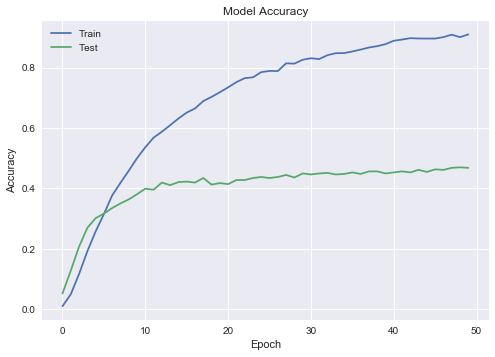

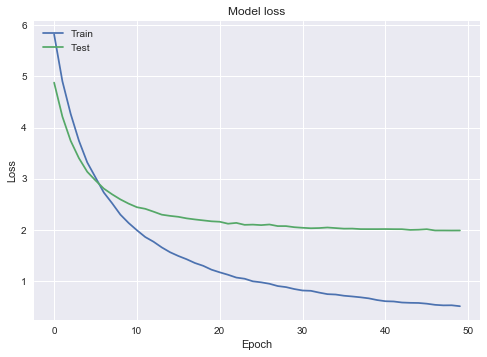

In [35]:
#%% Trains for 5 epochs.
if args.train_using_builtin_fit_method:

    model.compile(optimizer=optimizers.SGD(lr=0.01/10, momentum = 0.9), 
                  loss=[categorical_crossentropy], 
                  metrics=['accuracy'])


    #%%
    save_path=weights_path+'/model_transfer.{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only = True)
    callbacks_list = [checkpoint]
    #%%
    history = model.fit(train_gen, epochs=50, verbose=1, callbacks=callbacks_list, validation_data=test_gen, shuffle=True)
    
    plt.style.use('seaborn')
    #plt.style.available
    #['fivethirtyeight',
     #'seaborn-pastel',
     #'seaborn-whitegrid',
     #'ggplot',
     #'grayscale']
    
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_accuracy_'+db+'.png')
    
    # summarize history for loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_loss_'+db+'.png')
    
    #%% stop execution
    #sys.exit()

In [37]:
model.save_weights(filepath=weights_path+"/model_transfer_epoch_50.hdf5")

# **Now fine tune all layers at small learning rate**

# enable augmentation for increasing regularization for fine-tuning step

In [38]:
if args.imagenet_weights:
    print('using imagenet_weights')

    if args.dataset == 'cifar10':
        imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)
                                        #rescale = 1./255)

        train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
        test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)
    else:
        augment = True
        if not augment:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                            #rescale = 1./255,
                                            validation_split=0.1)
        else:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                        #rescale = 1./255,
                                        validation_split=0.1,
                                        
                              height_shift_range= 0.2, 
                              width_shift_range=0.2, 
                              rotation_range=15, 
                              shear_range = 0.2,
                              fill_mode = 'nearest',#''nearest#reflect
                              zoom_range=0.2)
        
        train_gen = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest')#,
                                #all classes for base model; binary classes for CF model
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen  = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest')#,
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                               # classes = label_map)
        
        # for visualization, dont use preprocessed image
        imgDataGen_nopreprocess = ImageDataGenerator(#preprocessing_function = preprocess_input, 
                                        rescale = 1./255,
                                        validation_split=0.1)
        
        train_gen_nopreprocess = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen_nopreprocess  = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        if args.dataset == 'CUB200' and official_split:
            #actual unseen test set
            imgDataGen_official_split = ImageDataGenerator(preprocessing_function = preprocess_input)
            actual_test_gen  = imgDataGen_official_split.flow_from_directory(data_dir_test,
                            target_size=(input_shape[1], input_shape[2]),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batch_size,
                            shuffle=False,
                            seed=None,
                            #subset='validation',
                            interpolation='nearest')
            imgDataGen_official_split_nopreprocess = ImageDataGenerator(rescale = 1./255)
            actual_test_gen_nopreprocess  = imgDataGen_official_split_nopreprocess.flow_from_directory(data_dir_test,
                            target_size=(input_shape[1], input_shape[2]),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batch_size,
                            shuffle=False,
                            seed=None,
                            #subset='validation',
                            interpolation='nearest')                            
elif args.dataset == 'cxr1000':
    train_gen, test_gen, valid_gen = load_cxr_dataset(train_df, test_df, valid_df, all_labels, batch_size)
    
else:
    print('not using imagenet_weights')

    imgDataGen = ImageDataGenerator(rescale = 1./255)

    train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
    test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)

using imagenet_weights
Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 169 steps, validate for 19 steps
Epoch 1/150
168/169 [============================>.] - ETA: 1s - loss: 1.1378 - accuracy: 0.6827
Epoch 00001: val_accuracy improved from -inf to 0.53535, saving model to ./trained_weights/resnet50/CUB200/standard/model_fine_tune.01-1.6051.hdf5
169/169 [==============================] - 232s 1s/step - loss: 1.1372 - accuracy: 0.6826 - val_loss: 1.6051 - val_accuracy: 0.5354
Epoch 2/150
168/169 [============================>.] - ETA: 1s - loss: 0.9466 - accuracy: 0.7452
Epoch 00002: val_accuracy improved from 0.53535 to 0.56229, saving model to ./trained_weights/resnet50/CUB200/standard/model_fine_tune.02-1.5339.hdf5
169/169 [==============================] - 209s 1s/step - loss: 0.9471 - accuracy: 0.7444 - val_loss: 1.5339 - val_accuracy: 0.5623
Epoch 3/150
168/169 [============================>.] - ETA: 1s - loss: 0.8798 - accuracy: 0.7604
Epoch 00003: val_accuracy improved from 0.56229 to 0.57

Epoch 54/150
168/169 [============================>.] - ETA: 1s - loss: 0.1665 - accuracy: 0.9693
Epoch 00054: val_accuracy did not improve from 0.66835
169/169 [==============================] - 204s 1s/step - loss: 0.1667 - accuracy: 0.9689 - val_loss: 1.1859 - val_accuracy: 0.6582
Epoch 55/150
168/169 [============================>.] - ETA: 1s - loss: 0.1638 - accuracy: 0.9672
Epoch 00055: val_accuracy did not improve from 0.66835
169/169 [==============================] - 203s 1s/step - loss: 0.1637 - accuracy: 0.9672 - val_loss: 1.2212 - val_accuracy: 0.6667
Epoch 56/150
168/169 [============================>.] - ETA: 1s - loss: 0.1558 - accuracy: 0.9762
Epoch 00056: val_accuracy did not improve from 0.66835
169/169 [==============================] - 202s 1s/step - loss: 0.1554 - accuracy: 0.9763 - val_loss: 1.2675 - val_accuracy: 0.6566
Epoch 57/150
168/169 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9724
Epoch 00057: val_accuracy did not improve from 

Epoch 110/150
168/169 [============================>.] - ETA: 1s - loss: 0.0739 - accuracy: 0.9881
Epoch 00110: val_accuracy did not improve from 0.68519
169/169 [==============================] - 203s 1s/step - loss: 0.0738 - accuracy: 0.9881 - val_loss: 1.2059 - val_accuracy: 0.6650
Epoch 111/150
168/169 [============================>.] - ETA: 1s - loss: 0.0628 - accuracy: 0.9924
Epoch 00111: val_accuracy did not improve from 0.68519
169/169 [==============================] - 202s 1s/step - loss: 0.0627 - accuracy: 0.9924 - val_loss: 1.2219 - val_accuracy: 0.6650
Epoch 112/150
168/169 [============================>.] - ETA: 1s - loss: 0.0697 - accuracy: 0.9916
Epoch 00112: val_accuracy did not improve from 0.68519
169/169 [==============================] - 198s 1s/step - loss: 0.0695 - accuracy: 0.9917 - val_loss: 1.2646 - val_accuracy: 0.6498
Epoch 113/150
168/169 [============================>.] - ETA: 1s - loss: 0.0647 - accuracy: 0.9916
Epoch 00113: val_accuracy did not improve f

Epoch 138/150
168/169 [============================>.] - ETA: 1s - loss: 0.0534 - accuracy: 0.9935
Epoch 00138: val_accuracy did not improve from 0.70034
169/169 [==============================] - 199s 1s/step - loss: 0.0535 - accuracy: 0.9935 - val_loss: 1.2091 - val_accuracy: 0.6785
Epoch 139/150
168/169 [============================>.] - ETA: 1s - loss: 0.0525 - accuracy: 0.9939
Epoch 00139: val_accuracy did not improve from 0.70034
169/169 [==============================] - 202s 1s/step - loss: 0.0524 - accuracy: 0.9939 - val_loss: 1.1800 - val_accuracy: 0.6785
Epoch 140/150
168/169 [============================>.] - ETA: 1s - loss: 0.0520 - accuracy: 0.9935
Epoch 00140: val_accuracy did not improve from 0.70034
169/169 [==============================] - 201s 1s/step - loss: 0.0521 - accuracy: 0.9935 - val_loss: 1.2029 - val_accuracy: 0.6700
Epoch 141/150
168/169 [============================>.] - ETA: 1s - loss: 0.0489 - accuracy: 0.9953
Epoch 00141: val_accuracy did not improve f

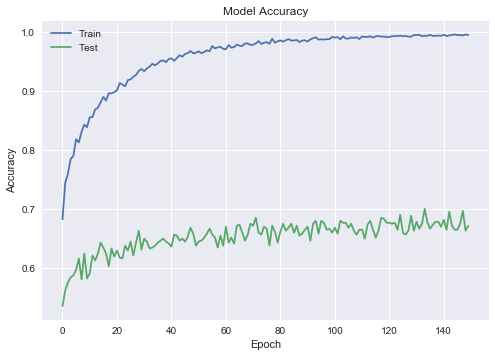

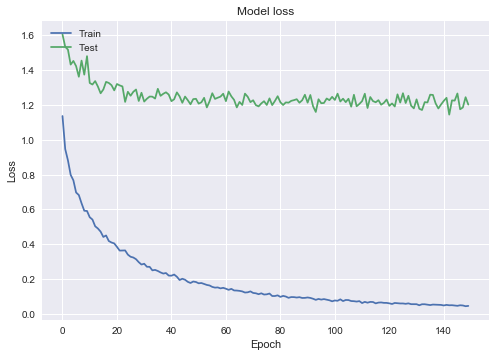

In [40]:
#%% Trains for 5 epochs.
if args.train_using_builtin_fit_method:
    model.trainable = True
    model.compile(optimizer=optimizers.SGD(lr=0.001/10, momentum = 0.9), 
                  loss=[categorical_crossentropy], 
                  metrics=['accuracy'])
    model.summary()
    
    model.load_weights(filepath=weights_path+'/model_transfer_epoch_50.hdf5')
    
    #%%
    save_path=weights_path+'/model_fine_tune.{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only = True)
    callbacks_list = [checkpoint]
    #%%
    history = model.fit(train_gen, epochs=150, verbose=1, callbacks=callbacks_list, validation_data=test_gen, shuffle=True)
    
    plt.style.use('seaborn')
    #plt.style.available
    #['fivethirtyeight',
     #'seaborn-pastel',
     #'seaborn-whitegrid',
     #'ggplot',
     #'grayscale']
    
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_accuracy_'+db+'.png')
    
    # summarize history for loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_loss_'+db+'.png')
    
    #%% stop execution
    #sys.exit()

In [41]:
model.save_weights(filepath=weights_path+"/model_fine_tune_epoch_150.hdf5")

In [44]:
#test accuracy on unseen data
if args.dataset == 'CUB200' and official_split:
    #load best weights
    #model.load_weights(filepath=weights_path+'/model_fine_tune.134-1.2162.hdf5')
    model.load_weights(filepath=weights_path+'/model_fine_tune_epoch_150.hdf5')
    
    #model.evaluate(actual_test_gen,verbose=1)
     
    pred_probs= model.predict(actual_test_gen,verbose=1)
    
    pred_classes = np.argmax(pred_probs,1)
    #actual_classes = np.argmax(test_gen.classes,1)
    actual_classes = actual_test_gen.classes
    print(confusion_matrix(actual_classes,pred_classes))
    print(classification_report(actual_classes,pred_classes)) 


182/182 [==============================] - 43s 239ms/step
[[17  3  6 ...  0  0  0]
 [ 1 19  1 ...  0  0  0]
 [ 3  1 19 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  0  0]
 [ 0  0  0 ...  2 25  0]
 [ 0  0  0 ...  0  0 28]]
              precision    recall  f1-score   support

           0       0.59      0.57      0.58        30
           1       0.61      0.63      0.62        30
           2       0.59      0.68      0.63        28
           3       0.67      0.87      0.75        30
           4       0.86      0.86      0.86        14
           5       0.90      0.82      0.86        11
           6       0.91      0.91      0.91        23
           7       0.60      0.67      0.63        18
           8       0.38      0.52      0.43        29
           9       0.87      0.87      0.87        30
          10       0.56      0.50      0.53        30
          11       1.00      0.81      0.89        26
          12       0.79      0.77      0.78        30
          13       0.75      

In [ ]:
model.evaluate(actual_test_gen,verbose=1)

In [ ]:
import os
for dirname, _, filenames in os.walk('./trained_weights'):
    for filename in filenames:
        print(os.path.join(dirname, filename))